In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
import math

# PYTORCH 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms, utils

### Import MIDI data 

In [114]:
num_files_desired = 1000

from importMIDI import ImportMIDI 
importedMIDI = ImportMIDI(num_files = num_files_desired)
imported_data_MIDI = importedMIDI.get_midi_data()

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=100)]: Done   2 tasks      | elapsed:    9.9s
[Parallel(n_jobs=100)]: Done   3 tasks      | elapsed:    9.9s
[Parallel(n_jobs=100)]: Done   4 tasks      | elapsed:   10.1s
[Parallel(n_jobs=100)]: Done   5 tasks      | elapsed:   10.4s
[Parallel(n_jobs=100)]: Done   6 tasks      | elapsed:   10.4s
[Parallel(n_jobs=100)]: Done   7 tasks      | elapsed:   10.7s
[Parallel(n_jobs=100)]: Done   8 tasks      | elapsed:   10.7s
[Parallel(n_jobs=100)]: Done   9 tasks      | elapsed:   13.9s
[Parallel(n_jobs=100)]: Done  10 tasks      | elapsed:   14.0s
[Parallel(n_jobs=100)]: Done  11 tasks      | elapsed:   14.0s
[Parallel(n_jobs=100)]: Done  12 tasks      | elapsed:   14.1s
[Parallel(n_jobs=100)]: Done  13 tasks      | elapsed:   14.2s
[Parallel(n_jobs=100)]: Done  14 tasks      | elapsed:   14.2s
[Parallel(n_jobs=100)]: Done  15 tasks 

### Split MIDI data

In [129]:
num_files = imported_data_MIDI.shape[0]

train_size = 0.60
val_size   = 0.30
test_size  = 0.10

val_index  = math.floor(num_files*train_size)
test_index = math.floor(num_files*(1-test_size))

train_data = imported_data_MIDI.iloc[0:val_index]
val_data   = imported_data_MIDI.iloc[val_index:test_index]
test_data  = imported_data_MIDI.iloc[test_index:]

In [130]:
print(num_files)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

87
(52, 9)
(26, 9)
(9, 9)


### Create dataset 

In [176]:
from dataset import MidiDataset

In [183]:
midi_train_dataset = MidiDataset(data = train_data, data_type = "train")
midi_val_dataset   = MidiDataset(data = val_data,   data_type = "val")
midi_test_dataset  = MidiDataset(data = test_data,  data_type = "test")

In [184]:
print(len(midi_train_dataset))
print(len(midi_val_dataset))
print(len(midi_test_dataset))

20544
8543
26491


In [185]:
trainloader = DataLoader(midi_train_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
valloader   = DataLoader(midi_val_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [186]:
test_batch_size = 256
testloader  = DataLoader(midi_test_dataset, batch_size=test_batch_size,
                        shuffle=False, num_workers=4)

In [187]:
print(len(testloader.dataset))

26491


### Create network

In [200]:
from models import Net
net = Net()

In [201]:
import torch.optim as optim
import torch.nn as nn

# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([50.0]))
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [202]:
net = net.double()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.cuda()
        labels
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.double())
        loss = criterion(outputs, labels.double())
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 100 == 0:   
            print("Epoch: ", epoch, ", Iter, ", i, ", Loss: ", loss.item())

print('Finished Training')

Epoch:  0 , Iter,  0 , Loss:  1.0206322037533782
Epoch:  0 , Iter,  100 , Loss:  0.8856942612095908
Epoch:  0 , Iter,  200 , Loss:  0.9511102223917937
Epoch:  0 , Iter,  300 , Loss:  0.8197419729833857
Epoch:  0 , Iter,  400 , Loss:  1.0029097549872605
Epoch:  0 , Iter,  500 , Loss:  1.0062406397707004
Epoch:  0 , Iter,  600 , Loss:  0.8123197232256653
Epoch:  0 , Iter,  700 , Loss:  1.0591312734442022
Epoch:  0 , Iter,  800 , Loss:  0.9315050152594158
Epoch:  0 , Iter,  900 , Loss:  0.9310325742783361
Epoch:  0 , Iter,  1000 , Loss:  0.7434047276046076
Epoch:  0 , Iter,  1100 , Loss:  0.8627209713265571
Epoch:  0 , Iter,  1200 , Loss:  1.0569494915282536
Epoch:  0 , Iter,  1300 , Loss:  0.9171883058927309
Epoch:  0 , Iter,  1400 , Loss:  0.8411797864333292
Epoch:  0 , Iter,  1500 , Loss:  0.7893640057289117
Epoch:  0 , Iter,  1600 , Loss:  0.9219479768295146
Epoch:  0 , Iter,  1700 , Loss:  0.8980802387478051
Epoch:  0 , Iter,  1800 , Loss:  0.843500081411214
Epoch:  0 , Iter,  1900 ,

### Save the network

In [203]:
PATH = './midi_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network

In [212]:
PLAYING_THRESH = 0.5

num_notes = 128

test_labels = np.zeros((len(testloader.dataset), num_notes))
test_preds  = np.zeros((len(testloader.dataset), num_notes))

sigmoid = torch.nn.Sigmoid()

with torch.no_grad():
    idx = 0
    for data in testloader:
        inputs, labels = data
    
        test_labels[idx:idx+labels.shape[0], :] = labels.cpu().numpy()

        outputs = net(inputs)
        outputs = sigmoid(outputs)

        test_preds[idx:idx+labels.shape[0], :] = outputs.cpu().numpy()
        
        idx = idx + labels.shape[0]
 
import copy
test_preds_probs = copy.deepcopy(test_preds)

test_preds[test_preds <  PLAYING_THRESH] = 0
test_preds[test_preds >= PLAYING_THRESH] = 1

In [213]:
test_preds.shape

(26491, 128)

In [214]:
def evaluate_metrics(preds, labels): 
    correct = 0.0
    total = 0.0
    num_true_pos_label  = 0.0
    num_false_pos_label = 0.0
    num_pos_pred  = 0.0
    num_true_neg_label  = 0.0
    num_false_neg_label = 0.0
    num_neg_pred  = 0.0

    num_timesteps = labels.shape[0]

    for i in range(num_timesteps): 
        for j in range(num_notes):
            if (labels[i,j] == 1.0):
                num_pos_pred += 1.0
            else: 
                num_neg_pred += 1.0

            if (preds[i,j] == labels[i,j]): 
                if (preds[i,j] == 1.0):
                    num_true_pos_label += 1.0
                else: 
                    num_true_neg_label += 1.0
                correct += 1.0
            else: 
                if (preds[i,j] == 1.0): 
                    num_false_pos_label += 1.0
                else: 
                    num_false_neg_label += 1.0
            total += 1.0
            
    accuracy = correct/total 
    recall = num_true_pos_label / num_pos_pred
    
    return accuracy, recall 

### Get network metrics

In [215]:
accuracy, recall = evaluate_metrics(test_preds, test_labels)

In [216]:
print(accuracy)
print(recall)

0.8999548195613605
0.643544388891223


### PLOTS

In [217]:
def plot_data(x, y): 
    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(x, y, marker='_')
    plt.xlabel('Time (x0.01 s)')
    plt.ylabel('MIDI Pitch')
#     plt.ylim(top=384)
    plt.show()

(23801, 2)
(346071, 2)
(26491, 128)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


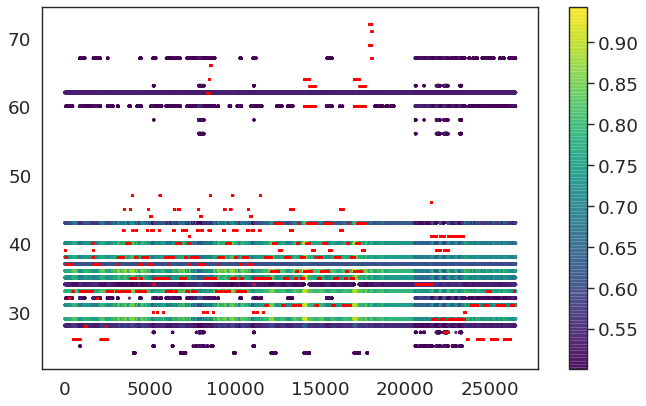

In [218]:
test_preds_plt = np.argwhere(test_preds > 0)
test_preds_plt_indices = np.where(test_preds > 0)
test_preds_colors = test_preds_probs[test_preds_plt_indices]

test_labels_plt = np.argwhere(test_labels > 0)


# print(test_preds_colors)
# plot_data(test_preds_plt[:,0], test_preds_plt[:,1])

print(test_labels_plt.shape)
print(test_preds_plt.shape)
print(test_preds.shape)
print(test_preds)

fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(test_preds_plt[:,0], test_preds_plt[:,1], c=test_preds_colors, cmap="viridis", alpha=0.75,  s=4)
plt.colorbar()
plt.scatter(test_labels_plt[:,0], test_labels_plt[:,1], c='r', s=1)


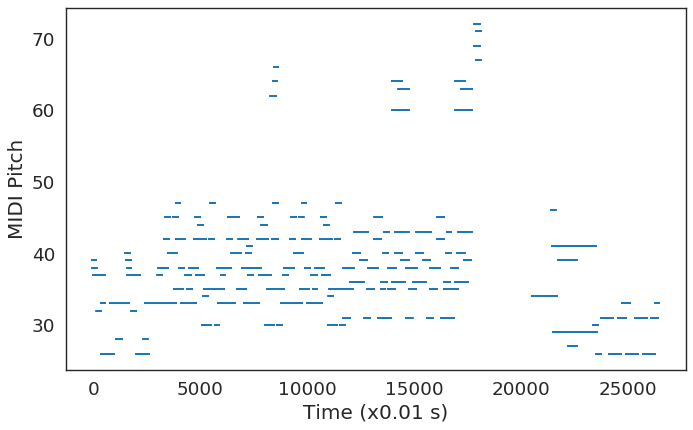

In [219]:
test_labels_plt = np.argwhere(test_labels > 0)
plot_data(test_labels_plt[:,0], test_labels_plt[:,1])

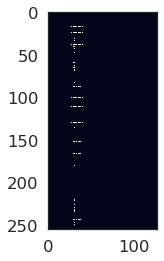

In [155]:
plt.imshow(outputs_np)

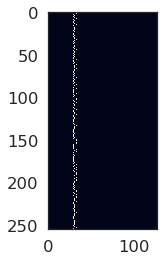

In [156]:
plt.imshow(labels)